In [1]:
import numpy as np
import pandas as pd
import random
import json
import csv

from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing import image
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from livelossplot import PlotLossesKeras
from keras_sequential_ascii import keras2ascii
import os
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split


Using TensorFlow backend.


In [2]:
import seaborn as sn
sn.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (20,10)
plt.rcParams.update({'font.size': 12})

In [3]:
TRAIN_DIR = '../sign-language-mnist/sign_mnist_train.csv'
TEST_DIR = '../sign-language-mnist/sign_mnist_test.csv'

ROWS = 28
COLS = 28
CHANNELS = 1

BATCH_SIZE=128

In [4]:
train = pd.read_csv(TRAIN_DIR)
test = pd.read_csv(TEST_DIR)

In [5]:
train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [6]:
test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


In [7]:
train.shape

(27455, 785)

In [8]:
test.shape

(7172, 785)

In [9]:
train_labels = train['label'].values
test_labels = test['label'].values

In [10]:
unique_val = np.array(train_labels)
unique_classes = np.unique(unique_val)
NUM_CLASSES = len(unique_classes)
print(f'Unique classes: {NUM_CLASSES}')

Unique classes: 24


In [11]:
unique_classes

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])

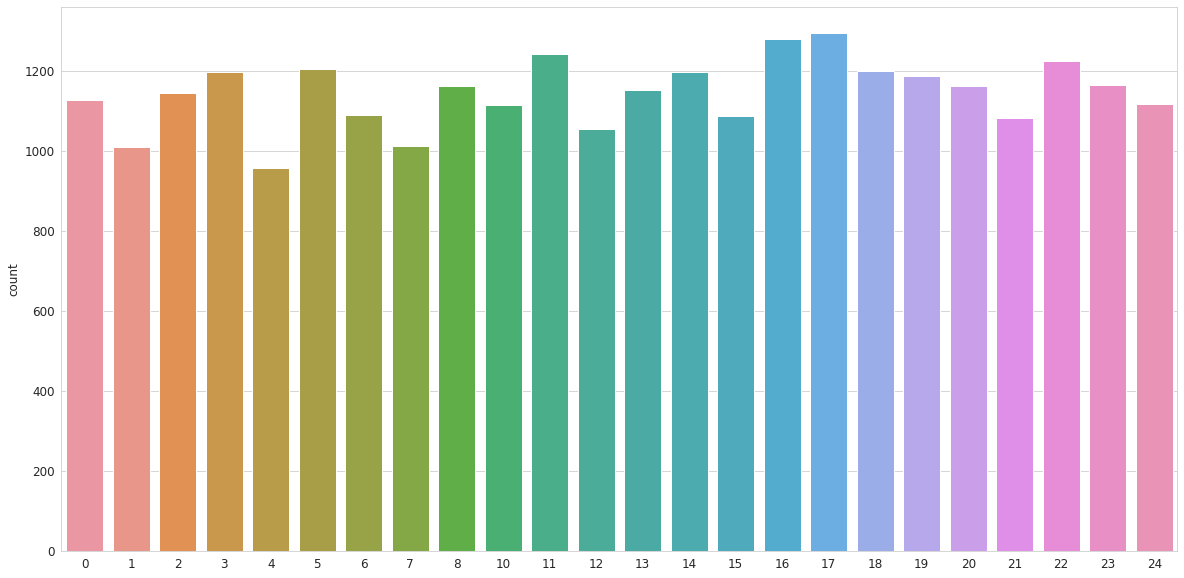

In [12]:
sn.countplot(train_labels)

In [13]:
label_binrizer = LabelBinarizer()
labels_bin_train = label_binrizer.fit_transform(train_labels)
labels_bin_test = label_binrizer.fit_transform(test_labels)
labels_bin_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]])

In [14]:
y_test = labels_bin_test

In [15]:
train.drop('label', axis = 1, inplace = True)
test.drop('label', axis = 1, inplace = True)

In [16]:
train.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,107,118,127,134,139,143,146,150,153,156,...,207,207,207,207,206,206,206,204,203,202
1,155,157,156,156,156,157,156,158,158,157,...,69,149,128,87,94,163,175,103,135,149
2,187,188,188,187,187,186,187,188,187,186,...,202,201,200,199,198,199,198,195,194,195
3,211,211,212,212,211,210,211,210,210,211,...,235,234,233,231,230,226,225,222,229,163
4,164,167,170,172,176,179,180,184,185,186,...,92,105,105,108,133,163,157,163,164,179


In [17]:
test.head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,149,149,150,150,150,151,151,150,151,152,...,138,148,127,89,82,96,106,112,120,107
1,126,128,131,132,133,134,135,135,136,138,...,47,104,194,183,186,184,184,184,182,180
2,85,88,92,96,105,123,135,143,147,152,...,68,166,242,227,230,227,226,225,224,222
3,203,205,207,206,207,209,210,209,210,209,...,154,248,247,248,253,236,230,240,253,255
4,188,191,193,195,199,201,202,203,203,203,...,26,40,64,48,29,46,49,46,46,53


In [18]:
images_train = train.values / 255
images_test = test.values / 255

Text(0.5, 0.98, 'Grayscale images')

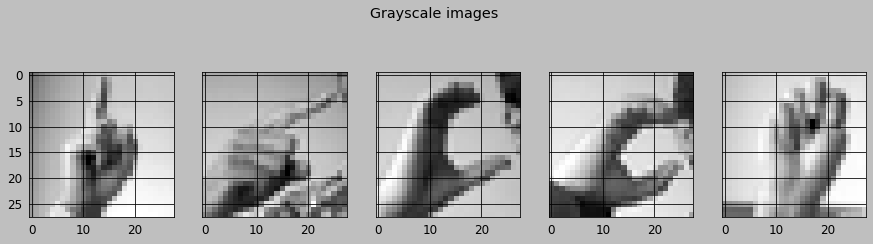

In [19]:
plt.style.use('grayscale')
fig, axs = plt.subplots(1, 5, figsize=(15, 4), sharey=True)
for i in range(5): 
        axs[i].imshow(images_train[i].reshape(28,28))
fig.suptitle('Grayscale images')

In [20]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(images_train, labels_bin_train, test_size = 0.3,
                                                  stratify = labels_bin_train, random_state = 43)

In [21]:
x_train = x_train.reshape(x_train.shape[0], ROWS, COLS ,CHANNELS)
x_val = x_val.reshape(x_val.shape[0], ROWS, COLS ,CHANNELS)
x_test = images_test.reshape(images_test.shape[0], ROWS, COLS ,CHANNELS)

In [22]:
print('Train: ', x_train.shape, y_train.shape)
print('Validation: ', x_val.shape, y_val.shape)
print('Test: ', x_test.shape, y_test.shape)

Train:  (19218, 28, 28, 1) (19218, 24)
Validation:  (8237, 28, 28, 1) (8237, 24)
Test:  (7172, 28, 28, 1) (7172, 24)


In [23]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(4,4), activation = 'relu', input_shape=(ROWS, COLS ,CHANNELS), padding='same'))
model.add(Dropout(0.4))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(64, kernel_size = (4, 4), activation = 'relu', padding='same' ))
model.add(Dropout(0.4))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu'))
model.add(Dropout(0.4))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(NUM_CLASSES, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])
keras2ascii(model)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     28   28    1
              Conv2D    \|/  -------------------      1088     0.8%
                relu   #####     28   28   64
             Dropout    | || -------------------         0     0.0%
                       #####     28   28   64
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####     14   14   64
              Conv2D    \|/  -------------------     65600    47.0%
                relu   #####     14   14   64
             Dropout    | || -------------------         0     0.0%
                       #####     14   14   64
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####      7    7   64
              Conv2D    \|/  -------------------     36928    26.5%
      

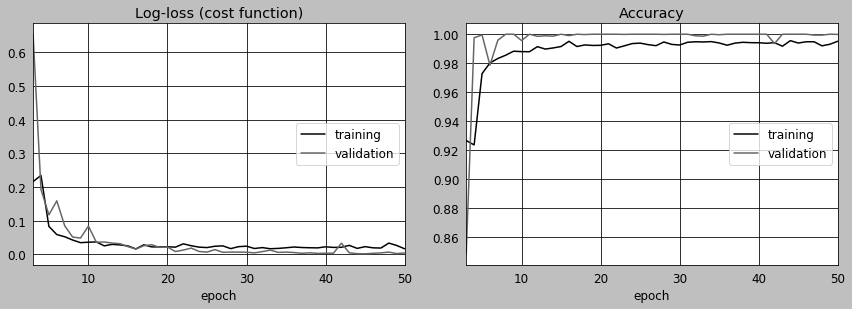

Log-loss (cost function):
training   (min:    0.016, max:    2.090, cur:    0.017)
validation (min:    0.002, max:    1.423, cur:    0.004)

Accuracy:
training   (min:    0.354, max:    0.996, cur:    0.995)
validation (min:    0.646, max:    1.000, cur:    1.000)


In [24]:
history = model.fit(x_train, y_train,
                    epochs=50,
                    batch_size=BATCH_SIZE,
                    validation_data=(x_val, y_val),
                    callbacks=[PlotLossesKeras()],
                    verbose=2)

In [25]:
y_pred = model.predict_classes(x_test)
evaluation1 = model.evaluate(x_test, y_test)
acc1 = accuracy_score(test_labels, y_pred)
f1_1 = f1_score(test_labels, y_pred, average='weighted')
print(evaluation1)
print('Accuracy: ', acc1)
print('F1 score: ', f1_1)
!telegram-send 'Model 1: Eval: {evaluation1} Acc: {acc1} F1: {f1_1}'

7172/7172 [==============================] - 2s 290us/step
[0.09921373493744272, 0.9714166201896264]
Accuracy:  0.4277746793084216
F1 score:  0.4253471542645834


/home/aksel/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/aksel/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [26]:
train_datagen = ImageDataGenerator(rotation_range=10,
                                   width_shift_range=0.05,
                                   height_shift_range=0.05,
                                   shear_range=0.1,
                                   zoom_range=0.075)

validation_datagen = image.ImageDataGenerator()

In [27]:
train_generator = train_datagen.flow(
    x_train,
    y_train,
    batch_size=BATCH_SIZE)

validation_generator = validation_datagen.flow(
    x_val,
    y_val,
    batch_size=BATCH_SIZE)

In [28]:
model = Sequential()
model.add(Conv2D(64, kernel_size=(4,4), activation = 'relu', input_shape=(ROWS, COLS ,CHANNELS), padding='same'))
model.add(Dropout(0.4))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(64, kernel_size = (4, 4), activation = 'relu', padding='same' ))
model.add(Dropout(0.4))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu'))
model.add(Dropout(0.4))
model.add(MaxPooling2D(pool_size = (2, 2)))

model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dense(NUM_CLASSES, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy',
              optimizer='nadam',
              metrics=['accuracy'])
keras2ascii(model)

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####     28   28    1
              Conv2D    \|/  -------------------      1088     0.8%
                relu   #####     28   28   64
             Dropout    | || -------------------         0     0.0%
                       #####     28   28   64
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####     14   14   64
              Conv2D    \|/  -------------------     65600    47.0%
                relu   #####     14   14   64
             Dropout    | || -------------------         0     0.0%
                       #####     14   14   64
        MaxPooling2D   Y max -------------------         0     0.0%
                       #####      7    7   64
              Conv2D    \|/  -------------------     36928    26.5%
                relu   #####      5    5   64
             Dropout    | || -------------------         0     0.0%
              

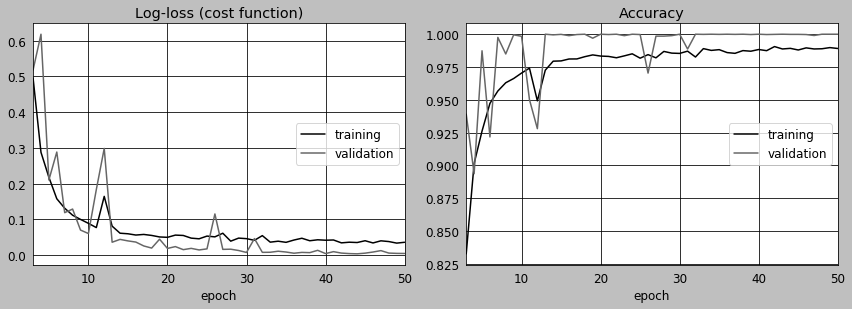

Log-loss (cost function):
training   (min:    0.034, max:    2.168, cur:    0.036)
validation (min:    0.004, max:    1.952, cur:    0.005)

Accuracy:
training   (min:    0.331, max:    0.991, cur:    0.989)
validation (min:    0.308, max:    1.000, cur:    1.000)


In [29]:
train_steps = len(x_train)/BATCH_SIZE
validation_steps = len(x_val)/BATCH_SIZE

history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[PlotLossesKeras()],
    verbose=2)

In [30]:
y_pred = model.predict_classes(x_test)
evaluation = model.evaluate(x_test, y_test)
acc1 = accuracy_score(test_labels, y_pred)
f1_1 = f1_score(test_labels, y_pred, average='weighted')
print(evaluation1)
print('Accuracy: ', acc1)
print('F1 score: ', f1_1)
!telegram-send 'Model 1: Eval: {evaluation1} Acc: {acc1} F1: {f1_1}'

7172/7172 [==============================] - 4s 522us/step
[0.019458772333980863, 0.9963747908533185]
Accuracy:  0.4369771332961517
F1 score:  0.43740135515078904


/home/aksel/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/aksel/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [31]:
x_train_t = np.stack([x_train.reshape(x_train.shape[0],28,28)]*3, axis=3).reshape(x_train.shape[0],28,28,3)
x_val_t = np.stack([x_val.reshape(x_val.shape[0],28,28)]*3, axis=3).reshape(x_val.shape[0],28,28,3)
x_test_t = np.stack([x_test.reshape(x_test.shape[0],28,28)]*3, axis=3).reshape(x_test.shape[0],28,28,3)
x_train_t.shape, x_val_t.shape, x_test_t.shape

((19218, 28, 28, 3), (8237, 28, 28, 3), (7172, 28, 28, 3))

In [32]:
# Resize the images 48*48 as required by VGG16
from keras.preprocessing.image import img_to_array, array_to_img
x_train_tt = np.asarray([img_to_array(array_to_img(im, scale=True).resize((48,48))) for im in x_train_t])/225
x_val_tt = np.asarray([img_to_array(array_to_img(im, scale=True).resize((48,48))) for im in x_val_t])/225
x_test_tt = np.asarray([img_to_array(array_to_img(im, scale=True).resize((48,48))) for im in x_test_t])/225
x_train_tt.shape, x_val_tt.shape, x_test_tt.shape

((19218, 48, 48, 3), (8237, 48, 48, 3), (7172, 48, 48, 3))

In [33]:
base_model = VGG16(include_top = False, weights = 'imagenet', pooling = 'avg', input_shape=(48, 48, 3))

In [34]:
model = Sequential()
model.add(base_model)

model.add(Dense(NUM_CLASSES, activation = 'softmax'))

model.layers[0].trainable = False
model.summary()
model.compile(loss='categorical_crossentropy',  
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])
model.summary()
keras2ascii(model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
dense_5 (Dense)              (None, 24)                12312     
Total params: 14,727,000
Trainable params: 12,312
Non-trainable params: 14,714,688
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
dense_5 (Dense)              (None, 24)                12312     
Total params: 14,727,000
Trainable params: 12,312
Non-trainable params: 14,714,688
_________________________________________________________________
           OPERATION           DATA DIMENS

In [35]:
train_datagen = ImageDataGenerator(rotation_range=10,
                                   width_shift_range=0.05,
                                   height_shift_range=0.05,
                                   shear_range=0.1,
                                   zoom_range=0.075)

validation_datagen = image.ImageDataGenerator()

In [36]:
train_generator = train_datagen.flow(
    x_train_tt,
    y_train,
    batch_size=BATCH_SIZE)

validation_generator = validation_datagen.flow(
    x_val_tt,
    y_val,
    batch_size=BATCH_SIZE)

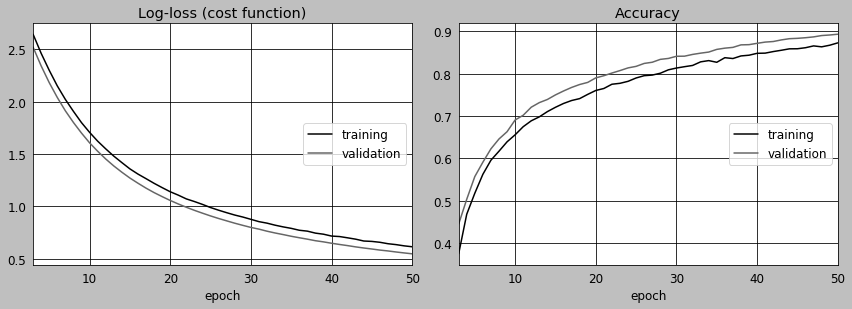

Log-loss (cost function):
training   (min:    0.614, max:    3.151, cur:    0.614)
validation (min:    0.546, max:    2.964, cur:    0.546)

Accuracy:
training   (min:    0.083, max:    0.873, cur:    0.873)
validation (min:    0.129, max:    0.893, cur:    0.893)


In [37]:
train_steps = len(x_train)/BATCH_SIZE
validation_steps = len(x_val)/BATCH_SIZE

history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=50,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[PlotLossesKeras()],
    verbose=2)

In [38]:
y_pred = model.predict_classes(x_test_tt)
evaluation1 = model.evaluate(x_test_tt, y_test)
acc1 = accuracy_score(test_labels, y_pred)
f1_1 = f1_score(test_labels, y_pred, average='weighted')
print(evaluation1)
print('Accuracy: ', acc1)
print('F1 score: ', f1_1)
!telegram-send 'Model 1: Eval: {evaluation1} Acc: {acc1} F1: {f1_1}'

7172/7172 [==============================] - 111s 16ms/step
[0.7324652449750927, 0.8073061907417736]
Accuracy:  0.3774400446179587
F1 score:  0.38386772436754946
